In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from langchain.prompts import ChatPromptTemplate
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

import tiktoken

In [3]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


# Importing transcripts

In [4]:
df_transcripts = pd.read_csv('../../data/transcripts_health_2021.csv')
df_transcripts.head()

,call_transcript,mood,agent_number,intention,resolution,Date
0,"Agent 3: Thank you for calling HealthHarbor, m...",neutral,3,Medical Advice or Symptom Assessment,resolved,2021-01-01 00:00:00.000000000
1,"Agent 2: Thank you for calling HealthHarbor, m...",neutral,2,General Inquiries,resolved,2021-01-01 08:44:41.081081081
2,"Agent 4: Thank you for calling HealthHarbor, m...",angry,4,Lab and Test Results,resolved,2021-01-01 17:29:22.162162162
3,"Agent 1: Thank you for calling HealthHarbor, m...",scared,1,Follow-up Calls and Care Management,resolved,2021-01-02 02:14:03.243243243
4,[Phone ringing]\n\nAgent 3: Thank you for call...,neutral,3,Medication Refills and Prescription Inquiries,resolved,2021-01-02 10:58:44.324324324


In [5]:
df_intention = pd.read_excel('../../data/intention_calls_health.xlsx', sheet_name='intention1')
df_intention

,ID,Intention Call Categories,Definition or Description
0,1,Appointment Scheduling,"Patients call to schedule, reschedule, or canc..."
1,2,Medical Advice or Symptom Assessment,"Patients seek guidance on managing symptoms, m..."
2,3,Medication Refills and Prescription Inquiries,Patients request refills for their medications...
3,4,Insurance and Billing Inquiries,Patients may have questions about their insura...
4,5,Lab and Test Results,Patients call to inquire about their test resu...
5,6,Referrals and Specialist Appointments,Patients may require assistance in getting ref...
6,7,Healthcare Facility Information,Patients seek information about healthcare fac...
7,8,Medical Records Requests,Patients may inquire about obtaining copies of...
8,9,Follow-up Calls and Care Management,Healthcare providers may follow up with patien...
9,10,General Inquiries,Patients might call with general questions abo...


In [6]:
df_transcripts.shape

(1000, 6)

In [7]:
num_tokens = []
for transcript in df_transcripts['call_transcript']:
    n_tokens = num_tokens_from_string(transcript, encoding_name="cl100k_base")
    num_tokens.append(n_tokens)


# General Plots and Visuals

Text(0.5, 1.0, 'Sentiment (Mood) distribution')

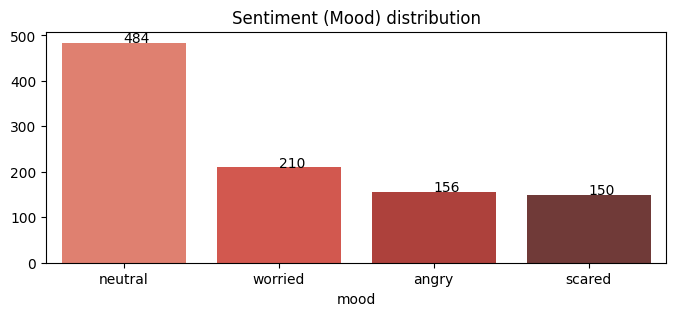

In [8]:
data = df_transcripts['mood'].value_counts()
plt.figure(figsize=(8, 3))
sns.barplot(x=data.index, y=data.values, palette="Reds_d")

#add values to the plot
for index, value in enumerate(data):
    plt.text(index, value, str(value))

#add title and labels
plt.title('Sentiment (Mood) distribution')

Text(0.5, 1.0, 'Agent distribution')

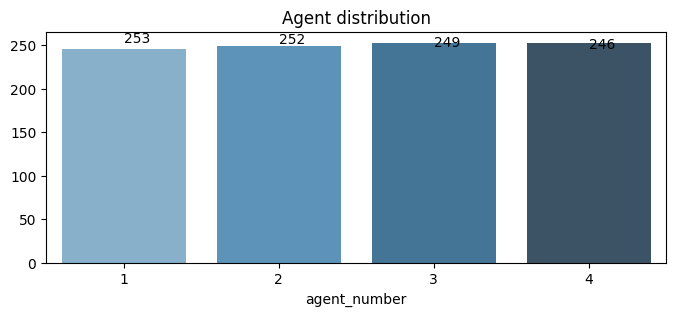

In [9]:
data = df_transcripts['agent_number'].value_counts()
plt.figure(figsize=(8, 3))
sns.barplot(x=data.index, y=data.values, palette="Blues_d")

#add values to the plot
for index, value in enumerate(data):
    plt.text(index, value, str(value))

#add title and labels
plt.title('Agent distribution')

Text(0.5, 1.0, 'Intention Calls Distribution')

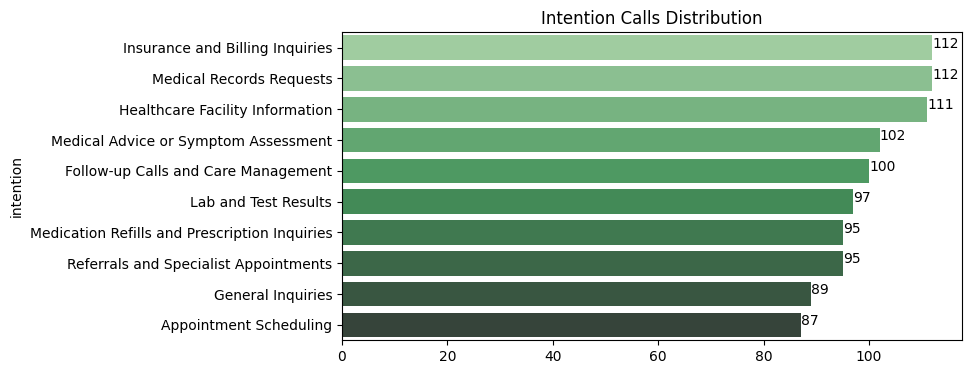

In [10]:
data = df_transcripts['intention'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(y=data.index, x=data.values, palette="Greens_d")

#add values to the plot
for index, value in enumerate(data):
    plt.text(value, index, str(value))

#add title and labels
plt.title('Intention Calls Distribution')

Text(0.5, 1.0, 'Resolution distribution')

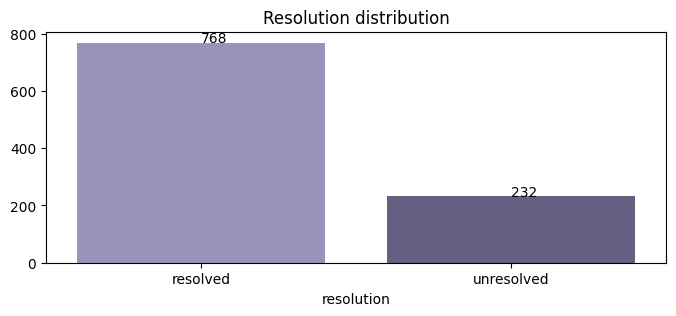

In [33]:
data = df_transcripts['resolution'].value_counts()
plt.figure(figsize=(8, 3))
sns.barplot(x=data.index, y=data.values, palette="Purples_d")

#add values to the plot
for index, value in enumerate(data):
    plt.text(index, value, str(value))

#add title and labels
plt.title('Resolution distribution')

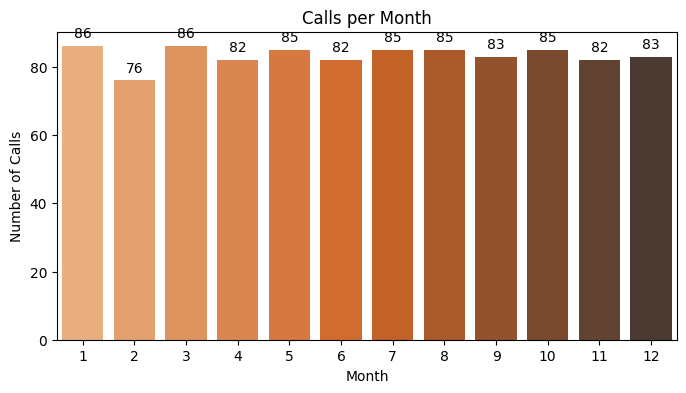

In [12]:
#change Date Column to datetime
df_transcripts['Date'] = pd.to_datetime(df_transcripts['Date'])

plt.figure(figsize=(8, 4))
ax = sns.countplot(x=df_transcripts['Date'].dt.month, palette="Oranges_d")

# Add values to each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

# Add title and labels
plt.title('Calls per Month')
plt.xlabel('Month')
plt.ylabel('Number of Calls')

plt.show()



# Tokens Analysis

/Users/urvog/miniconda3/envs/envCogniCall/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x300 with 0 Axes>

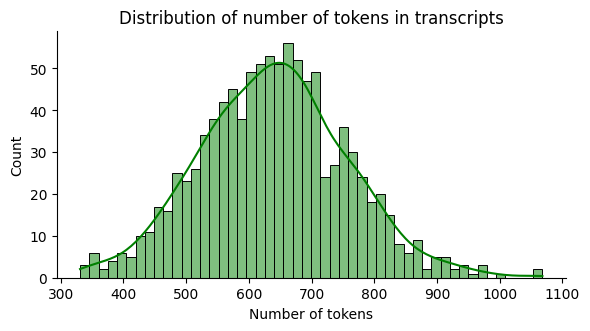

In [13]:
#distribution
plt.figure(figsize=(10, 3))
sns.displot(num_tokens, bins=50, kde=True, color='green', height=3, aspect=2)
plt.title('Distribution of number of tokens in transcripts')
plt.xlabel('Number of tokens')
plt.show()


<Axes: >

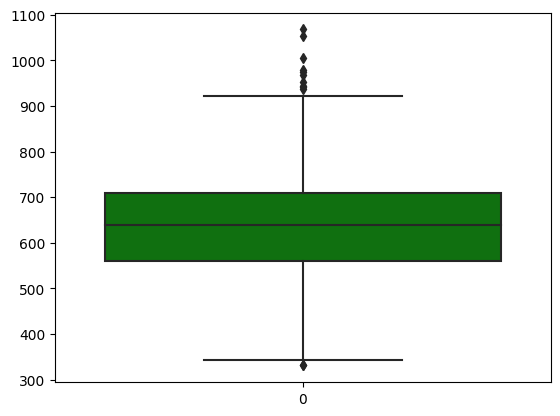

In [14]:
sns.boxplot(num_tokens, color='green')

# Prompts Analysis

## For Intention Calls Classification

In [15]:
prompt_template = ChatPromptTemplate.from_template(
"""
Based in the following transcript for a call center, classify the intention of the customer.

{transcript}

The possible intentions and their definitions or descriptions are the following:

{intentions}

If you can not classify the intention, you can use the "I don't know" option.

{format_instructions}

""")

In [16]:
#preparing schemas for output in JSON Format
intention_schema = ResponseSchema(name="intention",
                             description="""
                             The intention of customer call the posibble values are:%s"""
                             % str(list(df_intention['Intention Call Categories'])))
explanation_schema = ResponseSchema(name="explanation",
                                      description="""
                                      Explanation of the intention of customer call
                                      """)

response_schemas = [intention_schema, explanation_schema]
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
format_instructions = output_parser.get_format_instructions()

In [17]:
df_transcripts_clean = df_transcripts[['call_transcript']].copy()
df_transcripts_clean

num_tokens_intent_prompt = []

for transcript in df_transcripts_clean['call_transcript']:
    prompt_call = prompt_template.format_messages(transcript=transcript, 
                                              intentions=df_intention.iloc[:,1:],
                                              format_instructions=format_instructions)
    n_tokens_intent_prompt = num_tokens_from_string(prompt_call[0].content,encoding_name="cl100k_base")
    num_tokens_intent_prompt.append(n_tokens_intent_prompt)

/Users/urvog/miniconda3/envs/envCogniCall/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x300 with 0 Axes>

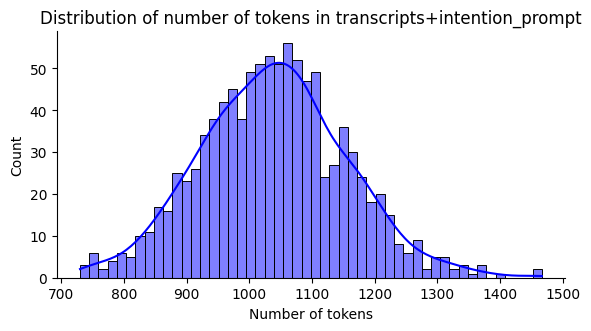

In [18]:
#distribution
plt.figure(figsize=(10, 3))
sns.displot(num_tokens_intent_prompt, bins=50, kde=True, color='Blue', height=3, aspect=2)
plt.title('Distribution of number of tokens in transcripts+intention_prompt')
plt.xlabel('Number of tokens')
plt.show()


<Axes: >

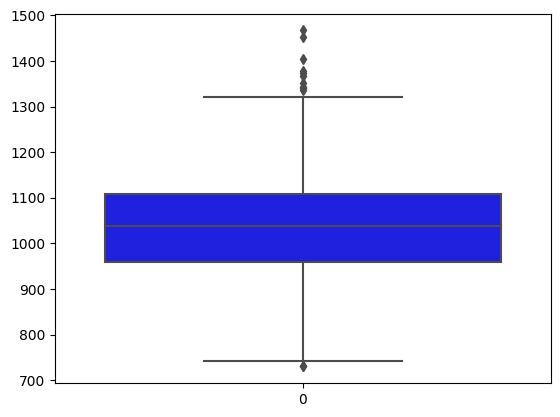

In [19]:
sns.boxplot(num_tokens_intent_prompt, color='blue')

## For Quality Check Calls Agent

In [20]:
df_script = pd.read_excel('../../data/scripts_call_center_ee.xlsx', sheet_name='general_script1')
df_script

,Step,Agent Script,Customer Response Options
0,Greeting,"""Good [morning/afternoon/evening], thank you f...",-
1,Identify Issue,"""Could you please tell me about the issue you'...","""[Describe issue]"""
2,Confirm Account Details,"""May I have your name and account number to pu...","""[Provide name and account number]"""
3,Verify Identity,"""For security, can you confirm your billing ad...","""[Provide verification information]"""
4,Analyze Issue,"""Thank you for that information. Let me review...",-
5,Provide Solution,"""I've looked into your issue, and it appears t...","""Yes/No"""
6,Schedule Technician,"""Would you like me to schedule a technician to...","""[Provide date and time]"""
7,Confirm Resolution,"""I have scheduled the technician for [date/tim...","""No, thank you"" / ""Yes, [describe other issue]"""
8,Closing,"""Thank you for calling [Company Name]. Have a ...","""Thank you, goodbye"""


In [21]:
prompt_template = ChatPromptTemplate.from_template(
"""
Based in the following transcript for a call center in health care institution:

{transcript}

Provide an score between 1 - 5 if following Script Quality Criteria is fulfilled:

{script_quality_criteria}

If you can't apply a criteria the check is False and the score is 0.

The ouput will be a JSON file with scores for each criteria (step) found in the transcript:

{format_instructions}

""")

In [22]:
#preparing schemas for output in JSON Format
QA01_Greeting_schema = ResponseSchema(name="qa01_greeting_schema",
                             description="""
                             Return an score from 1 to 5 based in the quality of the greeting criteria, 
                             return 0 if the greeting is not correct or not exist

                             The Score will be based in the following Agent Script: %s
                             
                             """
                             % str(df_script['Agent Script'][0]))

QA02_Identify_schema = ResponseSchema(name="qa02_identify_schema",
                             description="""
                             Return an score from 1 to 5 based in the quality  of the identification criteria, 
                             return 0 if the identification is not correct or not exist

                             The Score will be based in the following Agent Script: %s
                             """
                             % str(df_script['Agent Script'][1]))

QA03_confirm_schema = ResponseSchema(name="qa03_confirm_schema",
                             description="""
                             Return an score from 1 to 5 based in the quality of the confirmation criteria,
                             return 0 if the confirmation is not correct or not exist

                             The Score will be based in the following Agent Script: %s
                             """
                             % str(df_script['Agent Script'][2]))      

QA04_verify_schema = ResponseSchema(name="qa04_verify_schema",
                             description="""
                             Return an score from 1 to 5 based in the quality of the verification criteria,
                             return 0 if the verification is not correct or not exist

                             The Score will be based in the following Agent Script: %s
                             """
                             % str(df_script['Agent Script'][3]))      

QA05_analyze_schema = ResponseSchema(name="qa05_analyze_schema",
                             description="""
                             Return an score from 1 to 5 based in the quality of the analysis criteria,
                             return 0 if the analysis is not correct or not exist

                             The Score will be based in the following Agent Script: %s
                             """
                             % str(df_script['Agent Script'][4]))                      

QA06_solution_schema = ResponseSchema(name="qa06_solution_schema",
                             description="""
                             Return an score from 1 to 5 based in the quality of the solution criteria,
                             return 0 if the solution is not correct or not exist

                             The Score will be based in the following Agent Script: %s
                             """
                             % str(df_script['Agent Script'][5]))     

QA07_schedule_schema = ResponseSchema(name="qa07_schedule_schema",
                             description="""
                             Return an score from 1 to 5 based in the quality of the schedule criteria,
                             return 0 if the schedule is not correct or not exist

                             The Score will be based in the following Agent Script: %s
                             """
                             % str(df_script['Agent Script'][6]))       

QA08_resolution_schema = ResponseSchema(name="qa08_resolution_schema",
                             description="""
                             Return an score from 1 to 5 based in the quality of the resolution criteria,
                             return 0 if the resolution is not correct or not exist

                             The Score will be based in the following Agent Script: %s
                             """
                             % str(df_script['Agent Script'][7]))         

QA09_closing_schema = ResponseSchema(name="qa09_closing_schema",
                             description="""
                             Return an score from 1 to 5 based in the quality of the closing criteria,
                             return 0 if the closing is not correct or not exist

                             The Score will be based in the following Agent Script: %s
                             """
                             % str(df_script['Agent Script'][8]))          

response_schemas = [QA01_Greeting_schema, QA02_Identify_schema, QA03_confirm_schema, 
                    QA04_verify_schema, QA05_analyze_schema, QA06_solution_schema, 
                    QA07_schedule_schema, QA08_resolution_schema, QA09_closing_schema]
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
format_instructions = output_parser.get_format_instructions()

In [23]:
output_score_list = []
transcript_number = 1
tokens_list = []

num_tokens_quality_prompt = []

for transcript in df_transcripts['call_transcript']:
    prompt_call = prompt_template.format_messages(transcript=transcript, 
                                              script_quality_criteria=df_script,
                                              format_instructions=format_instructions)
    n_tokens_intent_prompt = num_tokens_from_string(prompt_call[0].content,encoding_name="cl100k_base")
    num_tokens_quality_prompt.append(n_tokens_intent_prompt)

/Users/urvog/miniconda3/envs/envCogniCall/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x300 with 0 Axes>

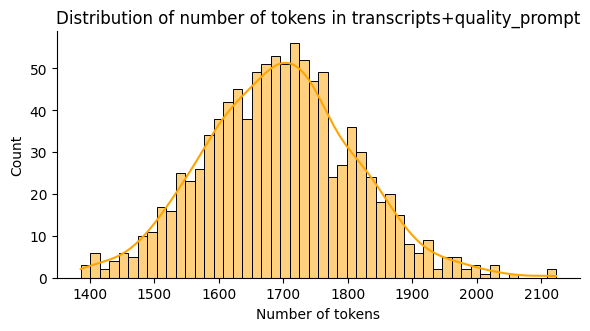

In [24]:
#distribution
plt.figure(figsize=(10, 3))
sns.displot(num_tokens_quality_prompt, bins=50, kde=True, color='Orange', height=3, aspect=2)
plt.title('Distribution of number of tokens in transcripts+quality_prompt')
plt.xlabel('Number of tokens')
plt.show()


<Axes: >

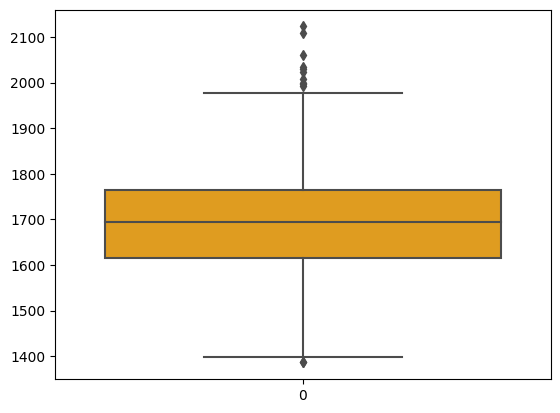

In [25]:
sns.boxplot(num_tokens_quality_prompt, color='Orange')

## Overall Prompts

In [26]:
df_prompts = pd.DataFrame([num_tokens,num_tokens_intent_prompt]).T
df_prompts.columns = ['num_tokens','num_tokens_intent_prompt']
df_prompts['diff_intent_prompt'] = df_prompts['num_tokens_intent_prompt'] - df_prompts['num_tokens']
df_prompts['num_tokens_quality_prompt'] = num_tokens_quality_prompt
df_prompts['diff_quality_prompt'] = df_prompts['num_tokens_quality_prompt'] - df_prompts['num_tokens']
df_prompts['total_tokens'] = df_prompts['num_tokens_intent_prompt']+df_prompts['num_tokens_quality_prompt']
df_prompts

,num_tokens,num_tokens_intent_prompt,diff_intent_prompt,num_tokens_quality_prompt,diff_quality_prompt,total_tokens
0,531,930,399,1586,1055,2516
1,633,1032,399,1688,1055,2720
2,631,1030,399,1686,1055,2716
3,654,1053,399,1709,1055,2762
4,435,834,399,1490,1055,2324
...,...,...,...,...,...,...
995,576,975,399,1631,1055,2606
996,384,783,399,1439,1055,2222
997,555,954,399,1610,1055,2564
998,777,1176,399,1832,1055,3008


In [27]:
df_prompts.sum()

num_tokens                    639894
num_tokens_intent_prompt     1038894
diff_intent_prompt            399000
num_tokens_quality_prompt    1694894
diff_quality_prompt          1055000
total_tokens                 2733788
dtype: int64

## Estimating Costs

In [28]:
print("Total Tokens Prompts")
df_prompts.sum()

Total Tokens Prompts


num_tokens                    639894
num_tokens_intent_prompt     1038894
diff_intent_prompt            399000
num_tokens_quality_prompt    1694894
diff_quality_prompt          1055000
total_tokens                 2733788
dtype: int64

In [29]:
print("Total estimated Costs for gpt-3.5-turbo-16k model")
df_prompts.sum()/1000*0.004

Total estimated Costs for gpt-3.5-turbo-16k model


num_tokens                    2.559576
num_tokens_intent_prompt      4.155576
diff_intent_prompt            1.596000
num_tokens_quality_prompt     6.779576
diff_quality_prompt           4.220000
total_tokens                 10.935152
dtype: float64

In [30]:
print("Total estimated Costs per 1K for gpt-3.5-turbo 4K model")
df_prompts.sum()/1000*0.002

Total estimated Costs per 1K for gpt-3.5-turbo 4K model


num_tokens                   1.279788
num_tokens_intent_prompt     2.077788
diff_intent_prompt           0.798000
num_tokens_quality_prompt    3.389788
diff_quality_prompt          2.110000
total_tokens                 5.467576
dtype: float64

In [31]:
print("Total estimated Costs for gpt-4-8k model")
df_prompts.sum()/1000*0.05

Total estimated Costs for gpt-4-8k model


num_tokens                    31.9947
num_tokens_intent_prompt      51.9447
diff_intent_prompt            19.9500
num_tokens_quality_prompt     84.7447
diff_quality_prompt           52.7500
total_tokens                 136.6894
dtype: float64